Ideas:

Use DBSCAN to detect anomalies in curriculumn access.

Use DBSCAN to detect anomalies in other products from the customers dataset.

Use DBSCAN to detect anomalies in number of bedrooms and finished square feet of property for the filtered dataset you used in the clustering project (single unit properties with a logerror).

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# DBSCAN import
from sklearn.cluster import DBSCAN

# Scaler import
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import env

In [2]:
def get_curriculum_logs():
    filename = "curriculum-access.csv"

    if os.path.isfile(filename):
        return pd.read_csv(filename, index_col=False)
    else:
        # read the SQL query into a dataframe
        url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/curriculum_logs'
        query = '''
        SELECT date,
               path as endpoint,
               user_id,
               cohort_id,
               ip as source_ip
        FROM logs;
        '''
        df = pd.read_sql(query, url)

        # Write that dataframe to disk for later.
        df.to_csv(filename, index = False)

        return df  

In [3]:
# acquire data using the above function
df = get_curriculum_logs()
df.head()

,date,endpoint,user_id,cohort_id,source_ip
0,2018-01-26,/,1,8.0,97.105.19.61
1,2018-01-26,java-ii,1,8.0,97.105.19.61
2,2018-01-26,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,javascript-i/conditionals,2,22.0,97.105.19.61


In [4]:
# convert date to a pandas datetime format and set as index
df.date = pd.to_datetime(df.date)
df = df.set_index(df.date)

In [5]:
page_views = df.groupby(['user_id'])['endpoint'].agg(['count', 'nunique'])
page_views

,count,nunique
user_id,,
1,7404,976
2,1541,151
3,1562,169
4,692,143
5,1701,197
...,...,...
977,86,12
978,55,18
979,127,20


In [6]:
# create the scaler
scaler = MinMaxScaler().fit(page_views)
# use the scaler
page_views_scaled_array = scaler.transform(page_views)
page_views_scaled_array[0:10]

array([[0.41329835, 1.        ],
       [0.08597588, 0.15384615],
       [0.08714828, 0.17230769],
       [0.03857749, 0.14564103],
       [0.09490844, 0.20102564],
       [0.07855069, 0.22974359],
       [0.10060295, 0.17435897],
       [0.02690933, 0.09128205],
       [0.03260384, 0.14871795],
       [0.05141804, 0.14666667]])

In [7]:
dbsc = DBSCAN(eps = 0.1, min_samples=3).fit(page_views_scaled_array)

In [9]:
columns = list(page_views.columns)
scaled_columns = ["scaled_" + column for column in columns]

In [10]:
# Create a dataframe containing the scaled values
scaled_df = pd.DataFrame(page_views_scaled_array, columns=scaled_columns, index=page_views.index)
scaled_df.head()

,scaled_count,scaled_nunique
user_id,,
1,0.413298,1.000000
2,0.085976,0.153846
3,0.087148,0.172308
4,0.038577,0.145641
5,0.094908,0.201026


In [11]:
page_views = page_views.merge(scaled_df, left_index=True, right_index=True)

In [12]:
labels = dbsc.labels_

In [13]:
page_views['labels'] = labels

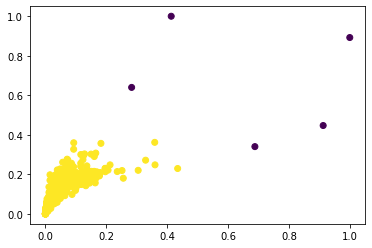

In [14]:
plt.scatter(page_views['scaled_count'], page_views['scaled_nunique'], c=page_views.labels)
plt.show()

In [15]:
# Lets cluster on groceries

In [17]:

url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/grocery_db'
sql = """
select *
from grocery_customers
"""

df = pd.read_sql(sql, url, index_col="customer_id")
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
customer_id,,,,,,,,
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [18]:
# Cluster on all or a selected subset of features
frozen_detergent_delicassen = df[["Frozen", "Detergents_Paper", "Delicassen"]]
frozen_detergent_delicassen.head(2)

,Frozen,Detergents_Paper,Delicassen
customer_id,,,
0,214,2674,1338
1,1762,3293,1776


In [19]:
# Make the scaler
scaler = MinMaxScaler().fit(frozen_detergent_delicassen)


# Use the scaler
frozen_detergent_delicassen = scaler.transform(frozen_detergent_delicassen)
frozen_detergent_delicassen

array([[0.0031063 , 0.0654272 , 0.02784731],
       [0.02854842, 0.08058985, 0.03698373],
       [0.03911643, 0.08605232, 0.16355861],
       ...,
       [0.00677142, 0.36346267, 0.03888194],
       [0.01664914, 0.00404174, 0.04426366],
       [0.00065742, 0.01161082, 0.00102211]])

In [20]:
# Make the object
dbsc = DBSCAN(eps = .10, min_samples = 5)

# Fit the object
dbsc.fit(frozen_detergent_delicassen)

DBSCAN(eps=0.1)

In [21]:
# Now, let's add the scaled value columns back onto the dataframe
columns = ["Frozen", "Detergents_Paper", "Delicassen"]
scaled_columns = ["Scaled_" + column for column in columns]

# Save a copy of the original dataframe
original_df = df.copy()

# Create a dataframe containing the scaled values
scaled_df = pd.DataFrame(frozen_detergent_delicassen, columns=scaled_columns)

# Merge the scaled and non-scaled values into one dataframe
df = df.merge(scaled_df, on=df.index)
df = df.drop(columns=['key_0'])
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Scaled_Frozen,Scaled_Detergents_Paper,Scaled_Delicassen
0,2,3,12669,9656,7561,214,2674,1338,0.003106,0.065427,0.027847
1,2,3,7057,9810,9568,1762,3293,1776,0.028548,0.080590,0.036984
2,2,3,6353,8808,7684,2405,3516,7844,0.039116,0.086052,0.163559
3,1,3,13265,1196,4221,6404,507,1788,0.104842,0.012346,0.037234
4,2,3,22615,5410,7198,3915,1777,5185,0.063934,0.043455,0.108093


In [22]:
df['labels'] = dbsc.labels_
df.labels.value_counts()

 0    428
-1     12
Name: labels, dtype: int64

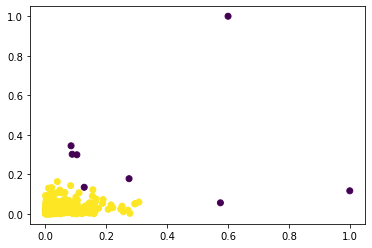

In [23]:
plt.scatter(df['Scaled_Frozen'], df['Scaled_Delicassen'], c=df.labels)
plt.show()

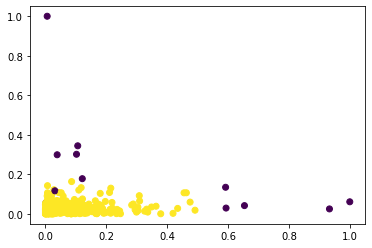

In [24]:
plt.scatter(df['Scaled_Detergents_Paper'], df['Scaled_Delicassen'], c=df.labels)
plt.show()

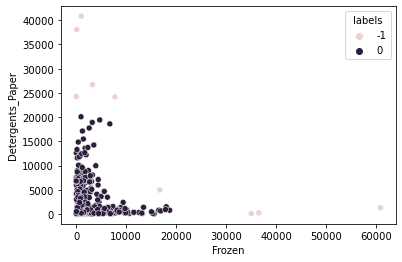

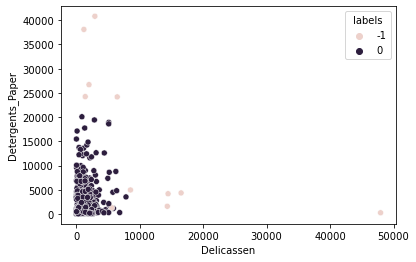

In [28]:
sns.scatterplot(df.Frozen, df.Detergents_Paper, hue=df.labels)
plt.show()

sns.scatterplot(df.Delicassen, df.Detergents_Paper, hue=df.labels)
plt.show()

### Getting a 3d view

Text(0.5, 0, 'Delicassen')

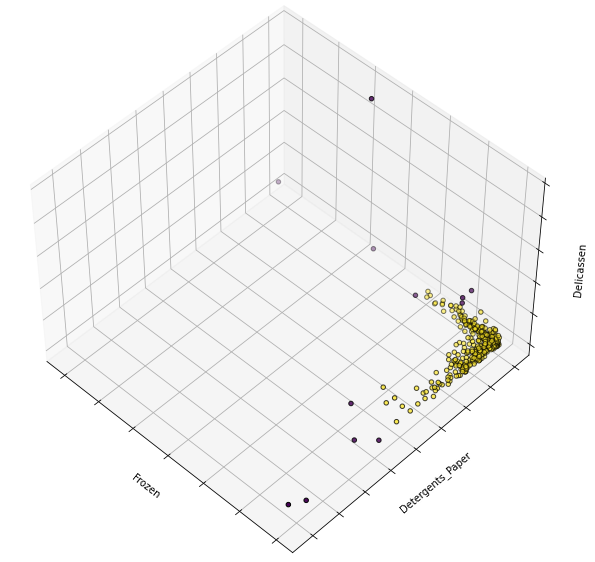

In [29]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(1, figsize=(8, 8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

# plot the points
ax.scatter(df.Frozen, df.Detergents_Paper, df.Delicassen,
           c=df.labels, edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

ax.set_xlabel('Frozen')
ax.set_ylabel('Detergents_Paper')
ax.set_zlabel('Delicassen')

#### Use DBSCAN to detect anomalies in number of bedrooms and finished square feet of property for the filtered dataset you used in the clustering project (single unit properties with a logerror).

In [2]:
url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/zillow'
sql = """
SELECT prop.*, 
       pred.logerror, 
       pred.transactiondate, 
       air.airconditioningdesc, 
       arch.architecturalstyledesc, 
       build.buildingclassdesc, 
       heat.heatingorsystemdesc, 
       landuse.propertylandusedesc, 
       story.storydesc, 
       construct.typeconstructiondesc 
FROM   properties_2017 prop  
       INNER JOIN (SELECT parcelid,
       					  logerror,
                          Max(transactiondate) transactiondate 
                   FROM   predictions_2017 
                   GROUP  BY parcelid, logerror) pred
               USING (parcelid) 
       LEFT JOIN airconditioningtype air USING (airconditioningtypeid) 
       LEFT JOIN architecturalstyletype arch USING (architecturalstyletypeid) 
       LEFT JOIN buildingclasstype build USING (buildingclasstypeid) 
       LEFT JOIN heatingorsystemtype heat USING (heatingorsystemtypeid) 
       LEFT JOIN propertylandusetype landuse USING (propertylandusetypeid) 
       LEFT JOIN storytype story USING (storytypeid) 
       LEFT JOIN typeconstructiontype construct USING (typeconstructiontypeid) 
WHERE  prop.latitude IS NOT NULL 
       AND prop.longitude IS NOT NULL AND transactiondate <= '2017-12-31';
"""

df_zillow = pd.read_sql(sql, url, index_col="id")
df_zillow.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
id,,,,,,,,,,,,,,,,,,,,,
1727539,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,NaN,...,6.059063e+13,0.025595,2017-01-01,None,None,None,None,Single Family Residential,None,None
1387261,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,...,6.111001e+13,0.055619,2017-01-01,None,None,None,None,Single Family Residential,None,None
11677,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,NaN,...,6.059022e+13,0.005383,2017-01-01,None,None,None,None,Single Family Residential,None,None
2288172,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,NaN,...,6.037300e+13,-0.103410,2017-01-01,None,None,None,Central,Single Family Residential,None,None
1970746,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,NaN,...,6.037124e+13,0.006940,2017-01-01,Central,None,None,Central,Condominium,None,None


In [3]:
df_zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77574 entries, 1727539 to 1187175
Data columns (total 67 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      77574 non-null  int64  
 1   airconditioningtypeid         25006 non-null  float64
 2   architecturalstyletypeid      206 non-null    float64
 3   basementsqft                  50 non-null     float64
 4   bathroomcnt                   77574 non-null  float64
 5   bedroomcnt                    77574 non-null  float64
 6   buildingclasstypeid           15 non-null     float64
 7   buildingqualitytypeid         49808 non-null  float64
 8   calculatedbathnbr             76959 non-null  float64
 9   decktypeid                    614 non-null    float64
 10  finishedfloor1squarefeet      6035 non-null   float64
 11  calculatedfinishedsquarefeet  77374 non-null  float64
 12  finishedsquarefeet12          73919 non-null  float6

In [4]:
# Create a function that will remove rows and columns that have missing values past a certain threshold.
def handle_missing_values(df, p_row = 0.84, p_col = 0.84):
    ''' function which takes in a dataframe, required notnull proportions of non-null rows and columns.
    drop the columns and rows columns based on theshold:'''
    
    #drop columns with nulls
    threshold = int(p_col * len(df.index)) # Require that many non-NA values.
    df.dropna(axis = 1, thresh = threshold, inplace = True)
    
    #drop rows with nulls
    threshold = int(p_row * len(df.columns)) # Require that many non-NA values.
    df.dropna(axis = 0, thresh = threshold, inplace = True)
    
    
    return df

In [5]:
df_zillow = handle_missing_values(df_zillow)
df_zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77474 entries, 1727539 to 1187175
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      77474 non-null  int64  
 1   bathroomcnt                   77474 non-null  float64
 2   bedroomcnt                    77474 non-null  float64
 3   calculatedbathnbr             76959 non-null  float64
 4   calculatedfinishedsquarefeet  77373 non-null  float64
 5   finishedsquarefeet12          73919 non-null  float64
 6   fips                          77474 non-null  float64
 7   fullbathcnt                   76959 non-null  float64
 8   latitude                      77474 non-null  float64
 9   longitude                     77474 non-null  float64
 10  lotsizesquarefeet             69300 non-null  float64
 11  propertycountylandusecode     77474 non-null  object 
 12  propertylandusetypeid         77474 non-null  float6

In [6]:
df_zillow = df_zillow.dropna()

In [7]:
# Cluster on all or a selected subset of features
bed_sqft = df_zillow[["bedroomcnt", "calculatedfinishedsquarefeet"]]
bed_sqft.head(2)

,bedroomcnt,calculatedfinishedsquarefeet
id,,
1727539,4.0,3100.0
1387261,2.0,1465.0


In [8]:
# create the scaler
scaler = MinMaxScaler().fit(bed_sqft)
# use the scaler
bed_sqft_scaled = scaler.transform(bed_sqft)
bed_sqft_scaled[0:10]

array([[0.36363636, 0.13537218],
       [0.18181818, 0.06029297],
       [0.27272727, 0.05009873],
       [0.36363636, 0.1021261 ],
       [0.27272727, 0.05326721],
       [0.27272727, 0.06153281],
       [0.36363636, 0.12903522],
       [0.18181818, 0.02690912],
       [0.36363636, 0.13257106],
       [0.18181818, 0.05225697]])

In [ ]:
dbsc = DBSCAN(eps = 0.1, min_samples=4).fit(bed_sqft_scaled)
print(dbsc)

In [ ]:
columns = list(bed_sqft.columns)
scaled_columns = ["scaled_" + column for column in columns]
scaled_columns

In [ ]:
# Create a dataframe containing the scaled values
scaled_df = pd.DataFrame(bed_sqft_scaled, columns=scaled_columns, index=bed_sqft.index)
scaled_df.head()

In [ ]:
# Merge the scaled and non-scaled values into one dataframe
bed_sqft = bed_sqft.merge(scaled_df, left_index=True, right_index=True)
bed_sqft

In [ ]:
labels = dbsc.labels_

In [ ]:
#add labels back to the dataframe
page_views['labels'] = labels

# how many unique labels (clusters) are created by DBSCAN?
page_views.labels.value_counts()

In [ ]:
plt.scatter(bed_sqft['scaled_'], bed_sqft['scaled_nunique'], c=page_views.labels)
plt.show()